## Total Loss 

* This project attempts to classify pictures of cars as either damaged or undamaged.


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.imports import *

## Dataset

* The data was (painstakingly) gathered from Google images

In [3]:
data_path = Path('./dataset')
data_path.ls()

[PosixPath('dataset/undamaged'),
 PosixPath('dataset/damaged'),
 PosixPath('dataset/models')]

In [4]:
damaged = get_image_files(data_path/'damaged')
damaged_lbls = ['damaged'] * len(damaged)

undamaged = get_image_files(data_path/'undamaged')
undamaged_lbls = ['undamaged'] * len(undamaged)

In [5]:
pat = r'/.*$'
data = ImageDataBunch.from_lists('./', damaged + undamaged, damaged_lbls + undamaged_lbls,
                                   ds_tfms=get_transforms(), size=256, bs=96).normalize(imagenet_stats)

The images are transformed using random rotation / zoom / skew (affine transformations) with a random probabilty (whatever the default is for get_transformations() works pretty well).  Each iteration (epoch) of training the network will have the possibility of seeing a different affine transformation of the training set.

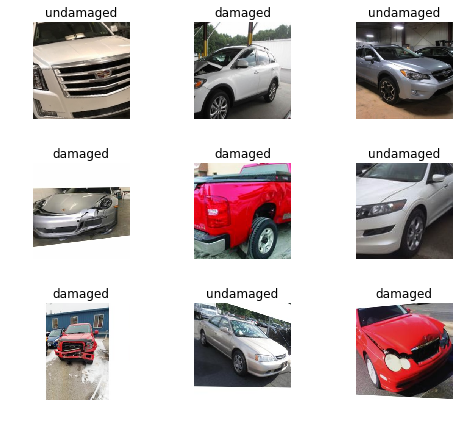

In [6]:
data.show_batch(rows=3, figsize=(7,6))

## Train the Model (1 stage)

The one-stage model utilizes a pre-trained ResNet model on a single training iteration of the images. 

We'll use this as a baseline for comparison to the 2 stage model (which should be much better)

In [7]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

The below utility helps to identify the learning rate that is suitable for the model.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-03


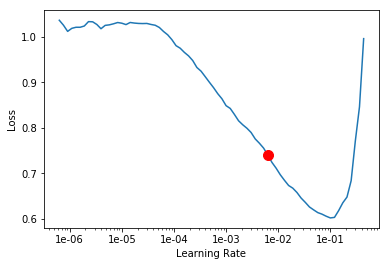

In [161]:
learn.lr_find()
learn.recorder.plot()

In [8]:
learn.fit_one_cycle(5, max_lr=slice(1e-4,1.5e-2))

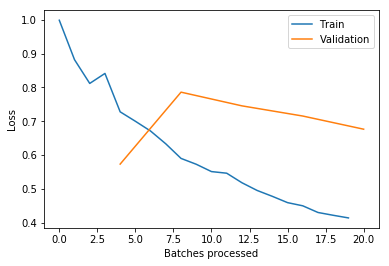

In [9]:
learn.recorder.plot_losses()

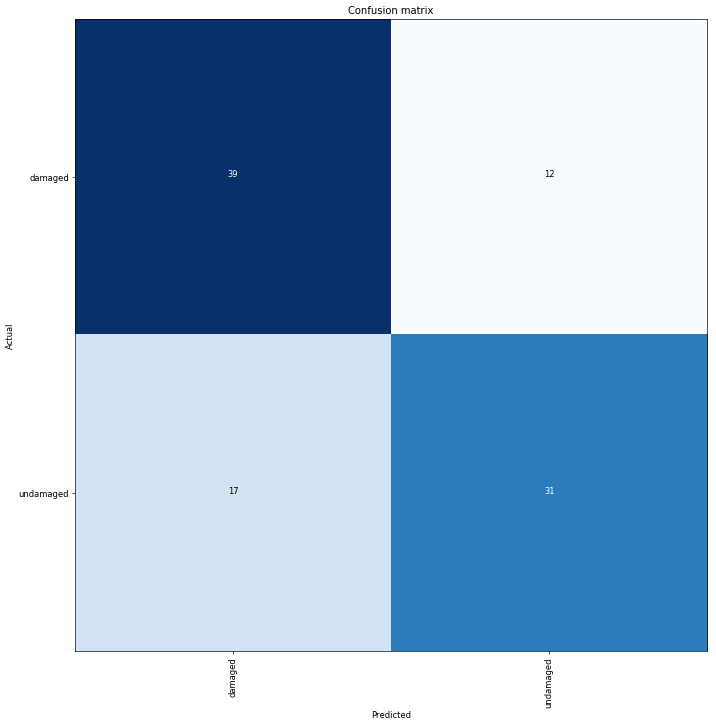

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Let's check the validation set activations to see the images that the neural network is mis-predicting on the worst (p=0 that damaged are damaged, or p=1 that undamaged are damaged).

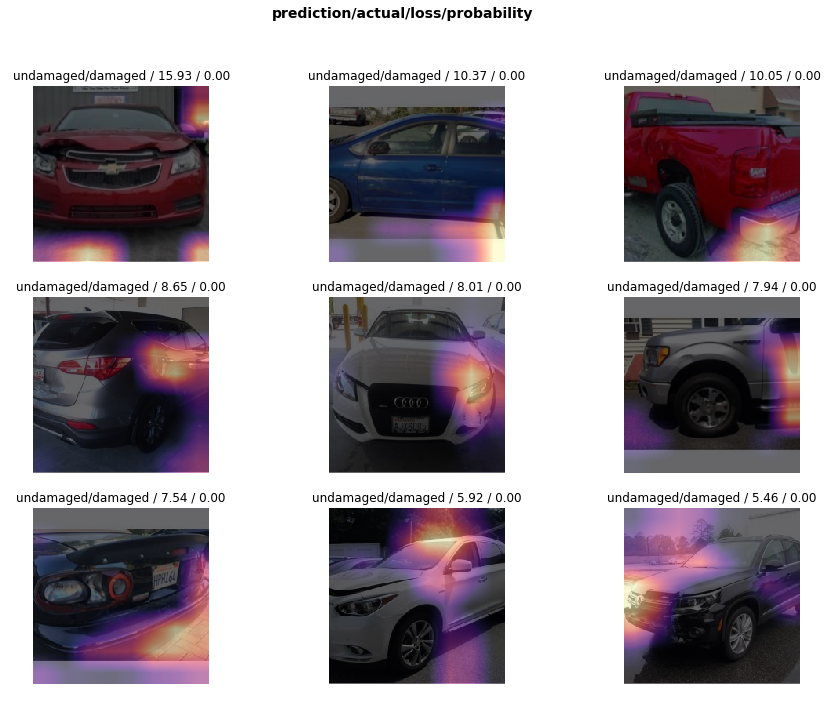

In [263]:
losses,idxs = interp.top_losses()
interp.plot_top_losses(9, figsize=(15,11))

## Validation


In [163]:
validation_path = Path('./validation')
validation_files_undamaged = get_image_files(validation_path/'undamaged')
validation_files_damaged = get_image_files(validation_path/'damaged')
undamaged_preds = [learn.predict(open_image(x)) for x in validation_files_undamaged]
damaged_preds = [learn.predict(open_image(x)) for x in validation_files_damaged]

Let's examine the hold-out set to see how it did:

In [165]:
damaged_preds

[(Category damaged, tensor(0), tensor([0.9948, 0.0052])),
 (Category damaged, tensor(0), tensor([1.0000e+00, 2.6421e-06])),
 (Category damaged, tensor(0), tensor([9.9972e-01, 2.7962e-04])),
 (Category undamaged, tensor(1), tensor([0.0838, 0.9162])),
 (Category undamaged, tensor(1), tensor([0.0295, 0.9705])),
 (Category damaged, tensor(0), tensor([1.0000e+00, 9.7044e-09])),
 (Category undamaged, tensor(1), tensor([0.1268, 0.8732])),
 (Category damaged, tensor(0), tensor([9.9979e-01, 2.1325e-04])),
 (Category damaged, tensor(0), tensor([9.9989e-01, 1.1323e-04])),
 (Category damaged, tensor(0), tensor([1.0000e+00, 1.3394e-06])),
 (Category damaged, tensor(0), tensor([9.9980e-01, 1.9613e-04])),
 (Category damaged, tensor(0), tensor([0.8409, 0.1591])),
 (Category undamaged, tensor(1), tensor([0.0036, 0.9964])),
 (Category damaged, tensor(0), tensor([0.9392, 0.0608]))]

Let's see an example of a mis-prediction:

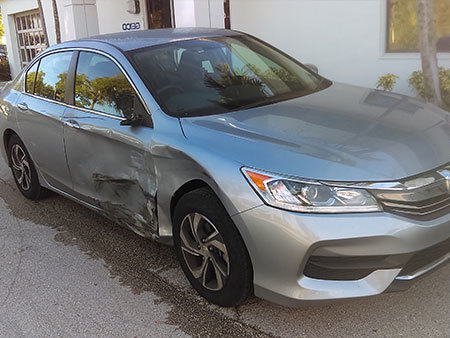

In [99]:
 open_image(validation_files_damaged[3])

In [166]:
undamaged_preds

[(Category undamaged, tensor(1), tensor([0.0034, 0.9966])),
 (Category undamaged, tensor(1), tensor([0.0324, 0.9676])),
 (Category undamaged, tensor(1), tensor([0.0259, 0.9741])),
 (Category undamaged, tensor(1), tensor([1.2812e-07, 1.0000e+00])),
 (Category undamaged, tensor(1), tensor([9.4213e-06, 9.9999e-01])),
 (Category undamaged, tensor(1), tensor([1.1683e-04, 9.9988e-01])),
 (Category undamaged, tensor(1), tensor([1.2129e-04, 9.9988e-01])),
 (Category undamaged, tensor(1), tensor([0.0167, 0.9833])),
 (Category undamaged, tensor(1), tensor([1.0606e-06, 1.0000e+00])),
 (Category undamaged, tensor(1), tensor([1.1922e-04, 9.9988e-01]))]

In [184]:
#learn.save("total_loss", return_path=True)

PosixPath('models/total_loss.pth')

## Train the Model (2 stage)

The two stage model will first be trained on lower resolution images that have more extreme transformations than the defaults.  It also uses a deeper network (ResNet101).  After initial training, the higher resolution images will be used for training with the default transformations.

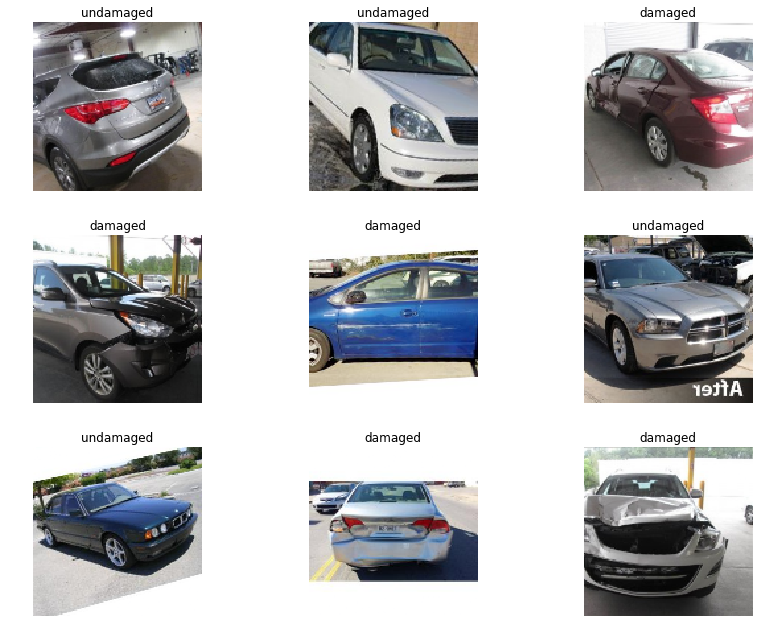

In [102]:
defaults.cmap='autumn'

src = ImageItemList.from_folder(Path('./dataset/'))\
                .random_split_by_pct(0.15)\
                .label_from_folder()

tfms = get_transforms(max_rotate=15, max_zoom=1.10, max_lighting=0.2, max_warp=0.1,
                      p_affine=.25, p_lighting=.25)

data = (src.transform(tfms, size=128, padding_mode='reflection')
        .databunch(bs=128).normalize(imagenet_stats))

data.show_batch(rows=3, figsize=(12,9))

In [109]:
learn = create_cnn(data, models.resnet101, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-03


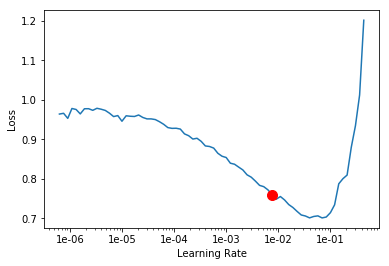

In [526]:
learn.lr_find()
learn.recorder.plot()

Perform the training using low-resolution images (with more noise from transformations)

In [110]:
lr = 2e-3
learn.fit_one_cycle(5, slice(lr/100,lr))

Load the higher resolution images and apply the default transformations.

In [111]:
tfms = get_transforms()
data = (src.transform(tfms, size=224)
        .databunch(bs=64).normalize(imagenet_stats))

learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-06


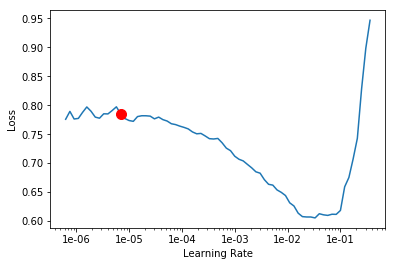

In [127]:
learn.lr_find()
learn.recorder.plot()

Perform the second stage of training.

In [113]:
lr = 5e-2
learn.fit_one_cycle(10, slice(lr/100, lr))

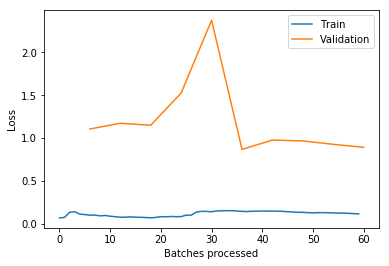

In [114]:
learn.freeze()
learn.recorder.plot_losses()

* Check the output on the validation (testing) set

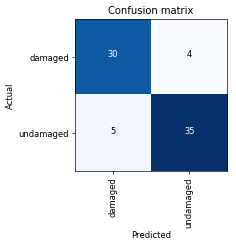

In [115]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(4,4), dpi=60)

Let's find the places that the model has the worst losses on the validation set.  The worst images that aren't getting any activation on the vehicle.

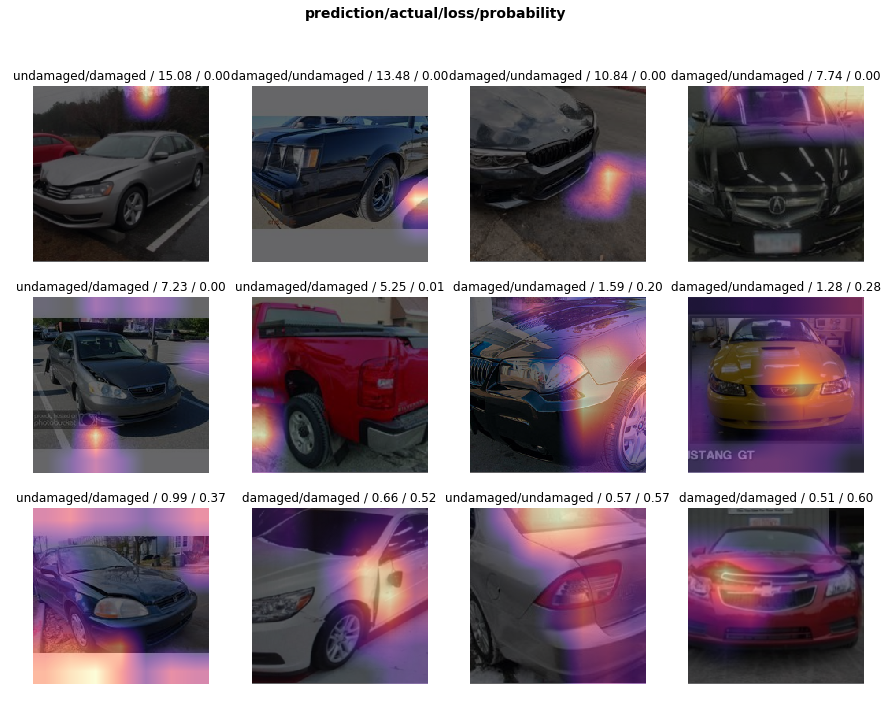

In [116]:
losses,idxs = interp.top_losses()
interp.plot_top_losses(12, figsize=(15,11))

## Check Activations (Training)

Let's inspect the activations on a few training images

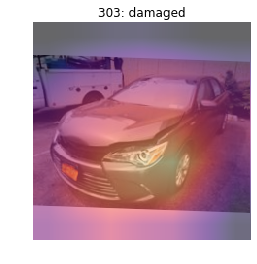

In [75]:
m = learn.model.eval();

idx=random.randint(0, len(data.train_ds))
x,y = data.train_ds[idx]

xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

from fastai.callbacks.hooks import *

def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

hook_a,hook_g = hooked_backward()
acts  = hook_a.stored[0].cpu()
acts.shape
avg_acts = acts.mean(0)
avg_acts.shape

def show_heatmap(hm, lbl):
    _,ax = plt.subplots()
    xb_im.show(ax, title=lbl)
    ax.imshow(hm, alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

show_heatmap(avg_acts, str(idx) + ': ' + str(data.train_ds.y[idx]))

## Check Activations (Hold-Out)

Using a separate data set (not the validation set in the epoch iterations), let's do a visual inspection of the activation regions to make sure the network isn't just being confused by some other source of bias in the images.

In [117]:
validation_src = ImageItemList.from_folder(Path('./validation/'))\
                .random_split_by_pct(0.0)\
                .label_from_folder()\
                .transform(tfms=None, size=224)

validation_data = validation_src.databunch(no_check=True).normalize(imagenet_stats)

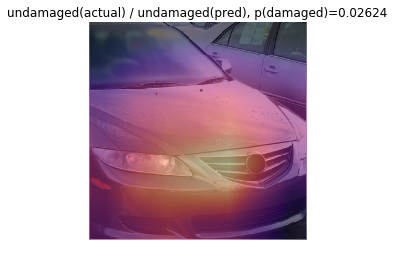

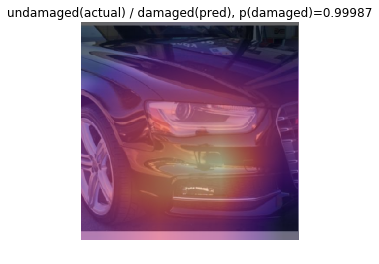

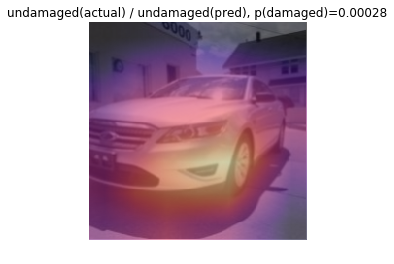

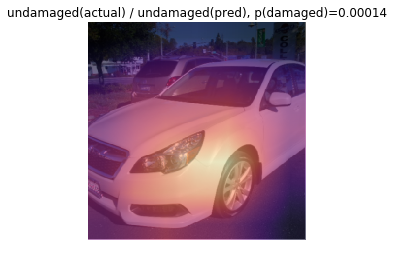

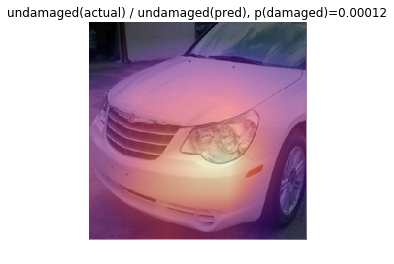

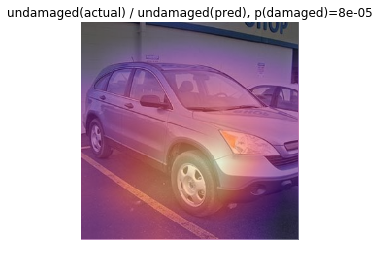

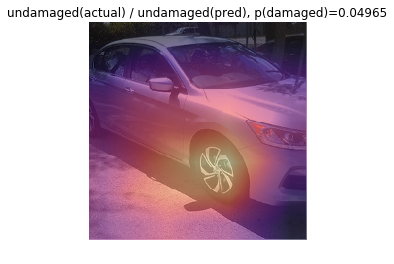

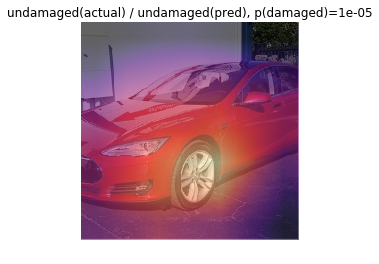

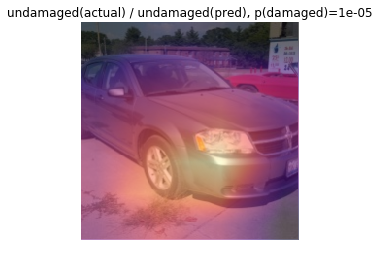

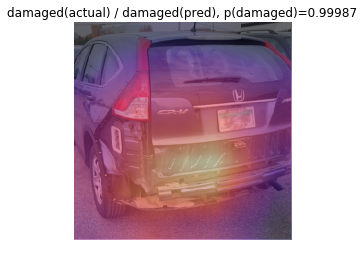

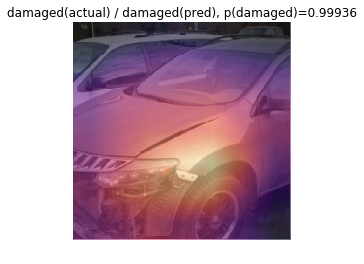

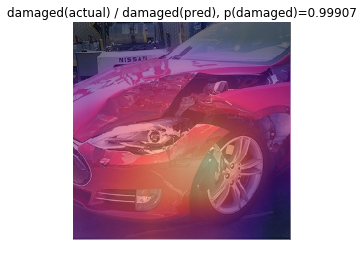

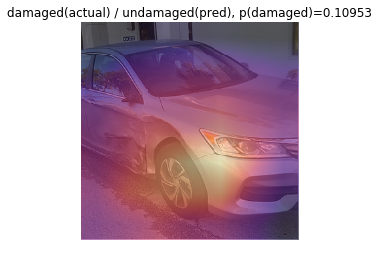

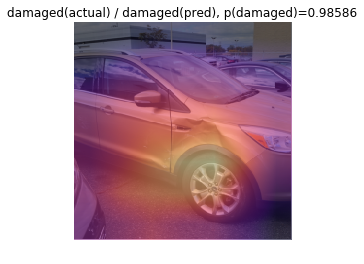

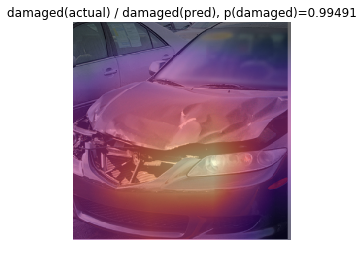

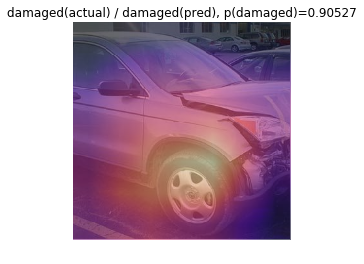

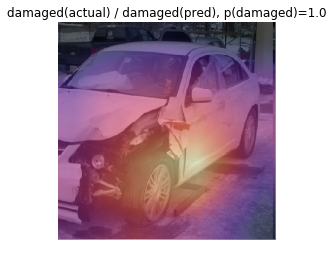

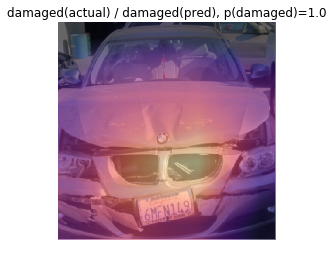

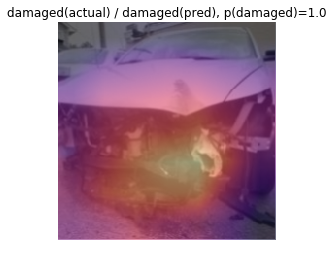

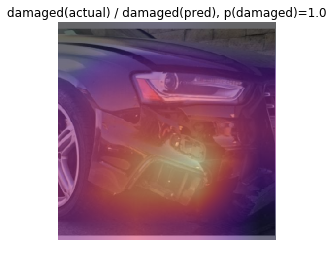

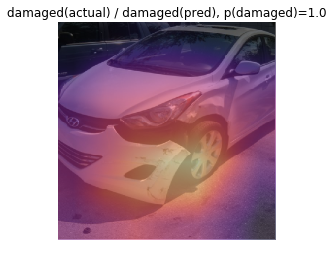

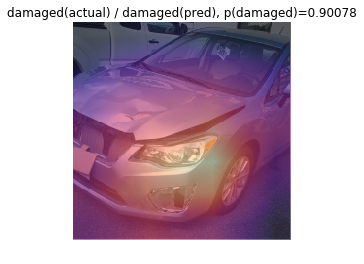

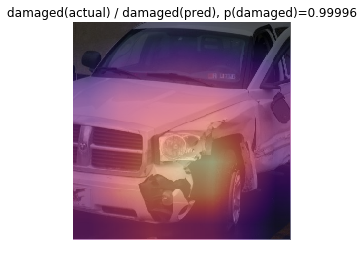

In [124]:
import matplotlib as mplot
mplot.rcParams.update({'figure.max_open_warning': 0})

for idx in range(1, len(validation_data.train_ds)):
    x,y = validation_data.train_ds[idx]
    xb,_ = validation_data.one_item(x)
    xb_im = Image(data.denorm(xb)[0])
    xb = xb.cuda()
    
    def hooked_backward(cat=y):
        with hook_output(m[0]) as hook_a: 
            with hook_output(m[0], grad=True) as hook_g:
                preds = m(xb)
                preds[0,int(cat)].backward()
        return hook_a,hook_g

    hook_a,hook_g = hooked_backward()

    def show_heatmap(hm, lbl):
        _,ax = plt.subplots()
        xb_im.show(ax, title=lbl)
        ax.imshow(hm, alpha=0.6, extent=(0,224,224,0),
                  interpolation='bilinear', cmap='magma');
    
    pred = learn.predict(x)
    show_heatmap(avg_acts, str(validation_data.train_ds.y[idx]) + '(actual) / ' + str(pred[0]) + '(pred), p(damaged)=' + str(round(pred[2][0].item(), 5)))


In [118]:
validation_path = Path('./validation')
validation_files_undamaged = get_image_files(validation_path/'undamaged')
validation_files_damaged = get_image_files(validation_path/'damaged')
undamaged_preds = [learn.predict(open_image(x)) for x in validation_files_undamaged]
damaged_preds = [learn.predict(open_image(x)) for x in validation_files_damaged]

Let's check the predictions and the associated probabilities (which is given as a 2d tensor, the first is the probability that it's damaged)

In [119]:
undamaged_preds

[(Category undamaged, tensor(1), tensor([7.4502e-04, 9.9926e-01])),
 (Category undamaged, tensor(1), tensor([0.0262, 0.9738])),
 (Category damaged, tensor(0), tensor([9.9987e-01, 1.3058e-04])),
 (Category undamaged, tensor(1), tensor([2.7708e-04, 9.9972e-01])),
 (Category undamaged, tensor(1), tensor([1.4440e-04, 9.9986e-01])),
 (Category undamaged, tensor(1), tensor([1.2220e-04, 9.9988e-01])),
 (Category undamaged, tensor(1), tensor([7.9859e-05, 9.9992e-01])),
 (Category undamaged, tensor(1), tensor([0.0496, 0.9504])),
 (Category undamaged, tensor(1), tensor([7.3855e-06, 9.9999e-01])),
 (Category undamaged, tensor(1), tensor([8.3071e-06, 9.9999e-01]))]

In [120]:
damaged_preds

[(Category damaged, tensor(0), tensor([9.9987e-01, 1.2917e-04])),
 (Category damaged, tensor(0), tensor([9.9936e-01, 6.3803e-04])),
 (Category damaged, tensor(0), tensor([9.9907e-01, 9.3171e-04])),
 (Category undamaged, tensor(1), tensor([0.1095, 0.8905])),
 (Category damaged, tensor(0), tensor([0.9859, 0.0141])),
 (Category damaged, tensor(0), tensor([0.9949, 0.0051])),
 (Category damaged, tensor(0), tensor([0.9053, 0.0947])),
 (Category damaged, tensor(0), tensor([1.0000e+00, 3.0528e-07])),
 (Category damaged, tensor(0), tensor([1.0000e+00, 6.9620e-08])),
 (Category damaged, tensor(0), tensor([1.0000e+00, 2.3082e-07])),
 (Category damaged, tensor(0), tensor([1.0000e+00, 3.5315e-08])),
 (Category damaged, tensor(0), tensor([1.0000e+00, 2.8856e-11])),
 (Category damaged, tensor(0), tensor([0.9008, 0.0992])),
 (Category damaged, tensor(0), tensor([9.9996e-01, 3.6626e-05]))]

In [125]:
learn.save('final-model-2stage', return_path=True)

PosixPath('dataset/models/final-model-2stage.pth')